In [81]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatch

times: 10 - estimated PI: 2.4
times: 100 - estimated PI: 3.12
times: 1000 - estimated PI: 3.12
times: 2000 - estimated PI: 3.13
times: 5000 - estimated PI: 3.1272
times: 10000 - estimated PI: 3.1156
times: 50000 - estimated PI: 3.14152
times: 100000 - estimated PI: 3.14648


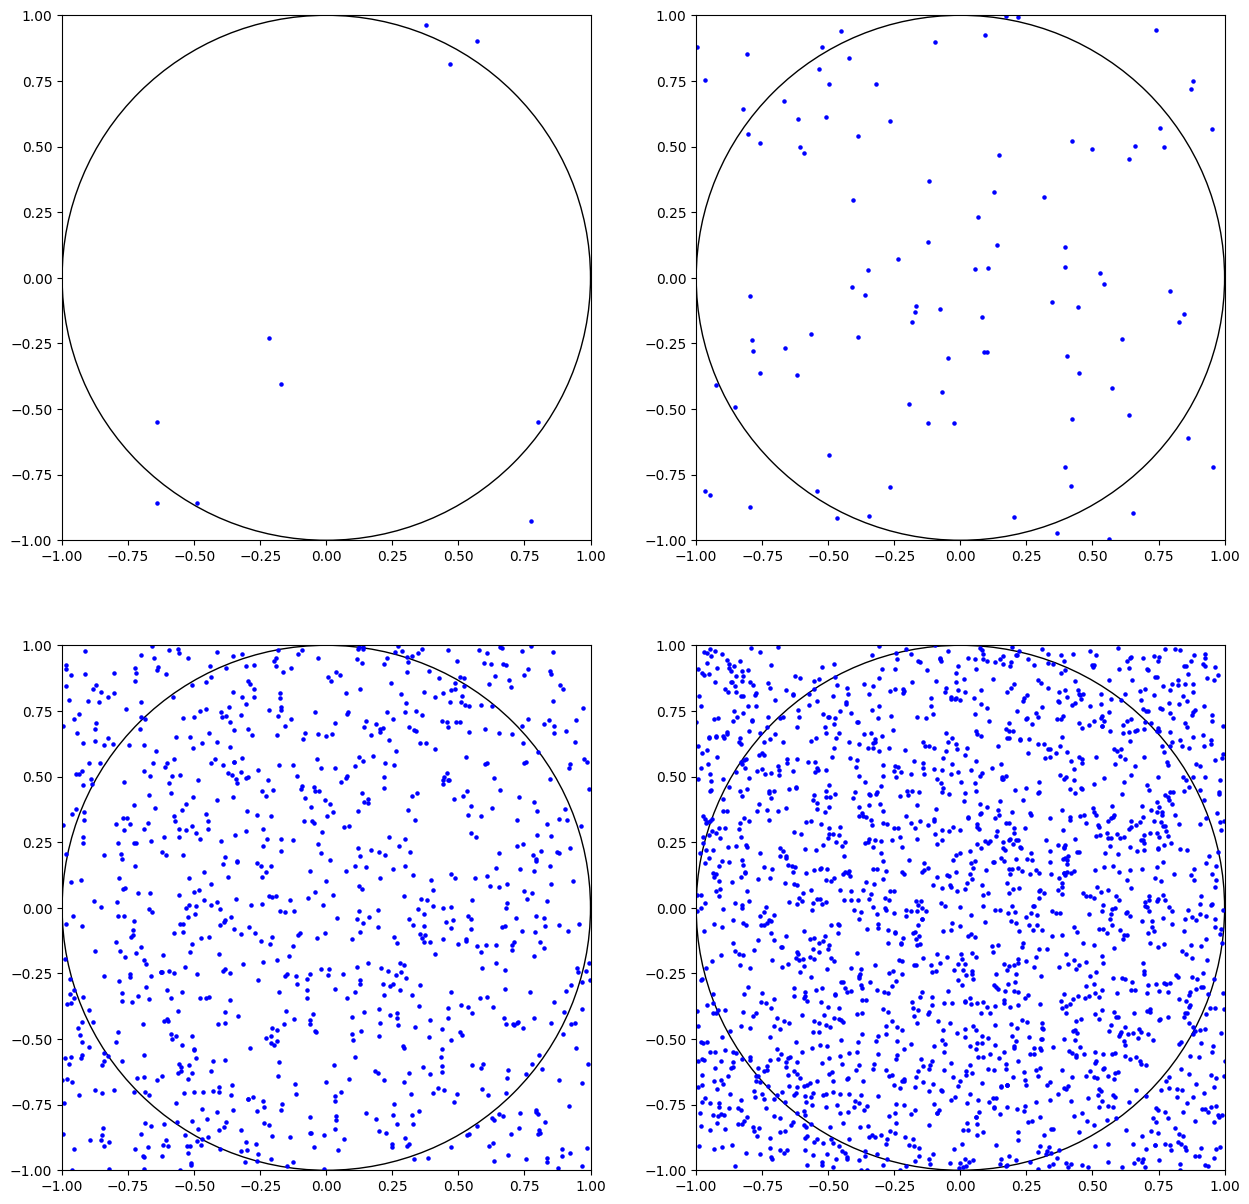

In [82]:
def moneteCarloPI(times: int, axes = None, plot = False):
    radius = 1
    inCircle = 0
    if(plot):
        axes.add_artist(pltpatch.Circle((0, 0), 1, fill = False))
    
    for i in range(times):
        x, y = [random.random() * 2 * radius - radius for _ in range(2)]
        inCircle += (x ** 2 + y ** 2 <= 1)
        
        if(plot):
            axes.scatter(x, y, color = 'blue', s = 5)
    return (inCircle / times * 4)



times = [10, 100, 1000, 2000]
figure, axes = plt.subplots(nrows = 2, ncols = 2 ,figsize = (15, 15)) 
plt.setp(axes, xlim = [-1, 1], ylim = [-1, 1])

for i in range(len(times)):
    print(f'times: {times[i]} - estimated PI: {moneteCarloPI(times[i], axes[i // 2][i % 2], True)}')

times = [5000, 10000, 50000, 100000]
for i in range(len(times)):
    print(f'times: {times[i]} - estimated PI: {moneteCarloPI(times[i])}')

plt.show()


In [53]:
class Mensch:
    def __init__(self, nBoard = 40, required_6_ToPlay = True, prizeFor_6 = True, enableHit = True) -> None:
        assert(nBoard % 4 == 0)
        self.n = nBoard
        self._first6 = required_6_ToPlay
        self._prize6 = prizeFor_6
        self._hit = enableHit

        self.remains: list[int]
        self.canPlay: list[int]
        self.remains = [self.n] * 4
        self.canPlay = [False] * 4

    def _reset_player(self, player: int):
        self.canPlay[player] = False
        self.remains[player] = self.n

    def reset(self):
        for i in range(4):
            self._reset_player(i)
     
    def _is_finished(self):
        for i in range(4):
            if(self.remains[i] == 0):
                return True
        return False
    
    def _get_winner(self):
        for i in range(4):
            if(self.remains[i] == 0):
                return i
        return -1
    
    def _check_hit(self, player: int):
        for i in range(4):
            if(i == player):
                continue
            difmod = (player - i) % 4
            if((self.remains[player] - self.remains[i]) == difmod * (self.n // 4) or
               (self.remains[player] - self.remains[i]) == (difmod - 4) * (self.n // 4)):
                self._reset_player(i)
                return

    def _move(self, player: int, moves: int):
        if(self.remains[player] >= moves):
            self.remains[player] -= moves
            if(self._hit):
                self._check_hit(player)

    def _roll(self):
        i = 0
        while(i < 4):
            dice = random.randint(1, 6)
            if(dice == 6):
                self.canPlay[i] = True
                self._move(i, dice)
                if(self._prize6):
                    continue
            elif(not self._first6 or self.canPlay[i]):
                self._move(i, dice)
            i += 1

            
    def play(self) -> int:
        while(not self._is_finished()):
            self._roll()
        return self._get_winner()

    
        
class MonteCarloMensch:
    def __init__(self, times: int, mensch: Mensch) -> None:
        self.mensch = mensch
        self.wins = [0] * 4
        self.winProbs = [0] * 4
        self.times = times

    def _eval(self):
        for i in range(4):
            self.winProbs[i] = self.wins[i] / self.times
        
    def simulate(self):
        for i in range(self.times):
            self.mensch.reset()
            winner = self.mensch.play()
            self.wins[winner] += 1
    
    def report(self):
        self._eval()
        print(self.winProbs)

mencsh = Mensch(
    nBoard = 40,
    required_6_ToPlay = True,
    prizeFor_6 = True,
    enableHit = True
)
monteCarloSim = MonteCarloMensch(100000, mencsh)
monteCarloSim.simulate()
monteCarloSim.report()

[0.26149, 0.2502, 0.24615, 0.24216]


In [59]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import astropy.visualization as astplt

class DistCLT:
    def __init__(self, size):
        self.mean: float
        self.SE: float
        self.s: float
        self.meanSamples: list[float]
        self.size = size

    def get_99_range(self):
        return [self.mean - 3 * self.SE, self.mean + 3 * self.SE]
    
    def get_mean(self):
        return self.mean
    
    def get_SE(self):
        return self.SE
    
    def get_s(self):
        return self.s

    def run(self):
        self.meanSamples = []
        for i in range(1000):
            samples = self.get_samples()
            self.meanSamples.append(samples.mean())

    def plot_clt_norm(self, ax = plt):
        start, stop = self.get_99_range()
        x = np.arange(start, stop, 0.01)
        y = stats.norm.pdf(x, self.mean, self.SE)
        ax.text(x.min(), y.max(), f'n: {self.size}, SE: {self.SE:.2f}', color='purple')
        ax.plot(x, y, 'red')

    def plot_sampling_hist(self, ax = plt):
        ax.hist(
            self.meanSamples, 
            bins = 'scott',
            alpha = 0.5,
            ec = 'black',
            density = True
        )
    
class PoissonDistCLT(DistCLT):
    def __init__(self, lmbda, size):
        super().__init__(size)
        self.lmbda = lmbda
        self.mean = self.lmbda
        self.s = np.sqrt(self.lmbda)
        self.SE = np.sqrt(self.lmbda) / np.sqrt(self.size)
    
    def get_samples(self):
        return np.random.poisson(lam=self.lmbda, size=self.size)

class ExpDistCLT(DistCLT):
    def __init__(self, scale, size):
        super().__init__(size)
        self.scale = scale
        self.mean =  self.scale
        self.s = self.scale
        self.SE = self.scale / np.sqrt(self.size)
    
    def get_samples(self):
        return np.random.exponential(scale=self.scale, size=self.size)
    
class GeomDistCLT(DistCLT):
    def __init__(self, p, size):
        super().__init__(size)
        self.p = p
        self.mean = 1 / self.p
        self.s = (np.sqrt(1 - self.p) / self.p)
        self.SE = (np.sqrt(1 - self.p) / self.p) / np.sqrt(self.size)
    
    def get_samples(self):
        return np.random.geometric(p=self.p, size=self.size)


In [62]:
nSamples = [30, 300, 3000]

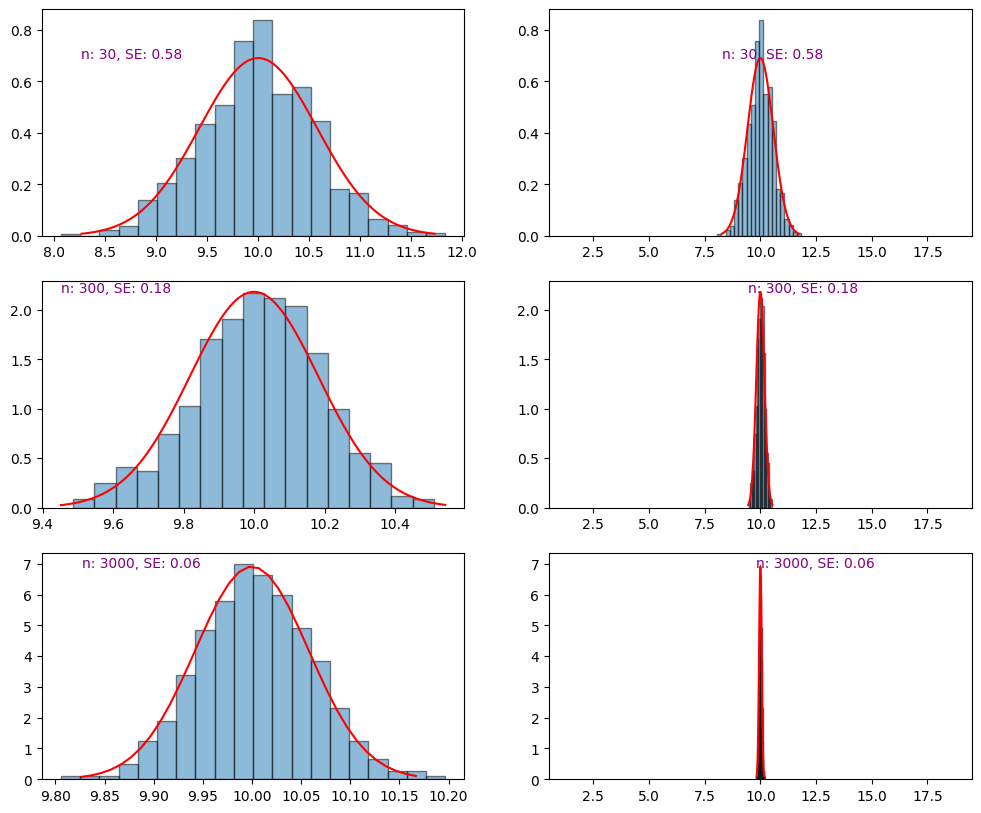

In [76]:
fig, axes = plt.subplots(3, 2, figsize=(12,10))
for i in range(3):
    dist = PoissonDistCLT(lmbda=10, size=nSamples[i])
    dist.run()
    dist.plot_clt_norm(axes[i][0])
    dist.plot_sampling_hist(axes[i][0])
    dist.plot_clt_norm(axes[i][1])
    dist.plot_sampling_hist(axes[i][1])
    plt.setp(axes[i][1], xlim = [dist.get_mean() - 3 * dist.get_s(), dist.get_mean() + 3 * dist.get_s()])
plt.show()

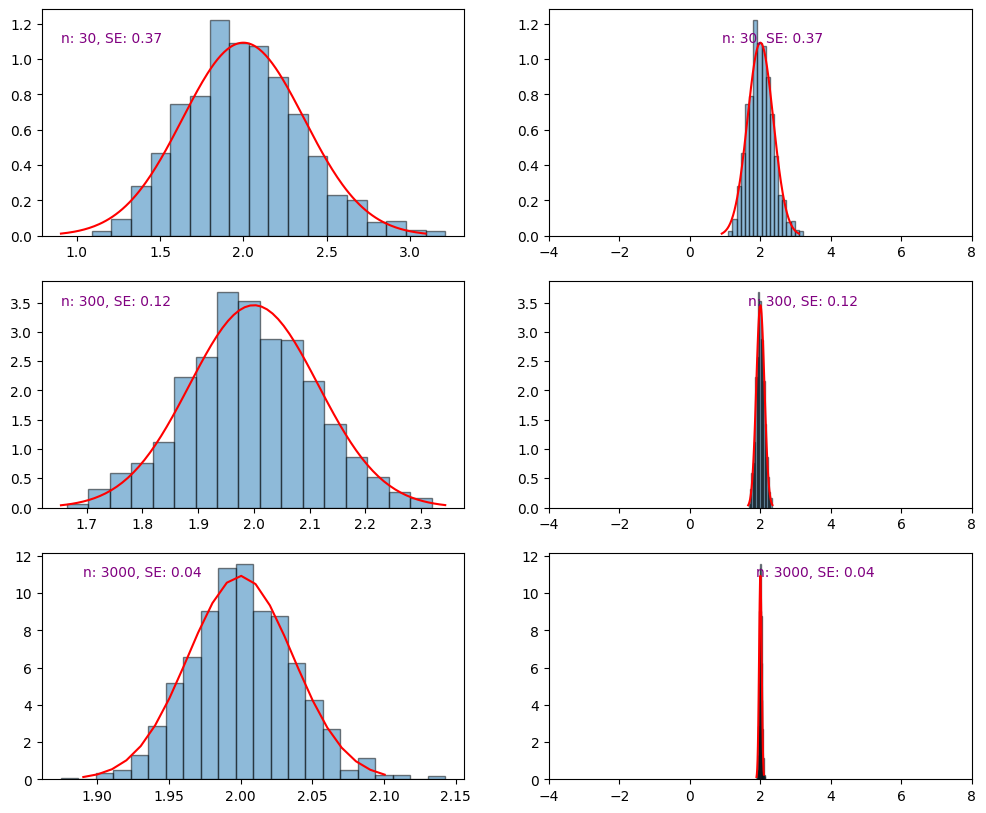

In [78]:
fig, axes = plt.subplots(3, 2, figsize=(12,10))
for i in range(3):
    dist = ExpDistCLT(scale=2, size=nSamples[i])
    dist.run()
    dist.plot_clt_norm(axes[i][0])
    dist.plot_sampling_hist(axes[i][0])
    dist.plot_clt_norm(axes[i][1])
    dist.plot_sampling_hist(axes[i][1])
    plt.setp(axes[i][1], xlim = [dist.get_mean() - 3 * dist.get_s(), dist.get_mean() + 3 * dist.get_s()])



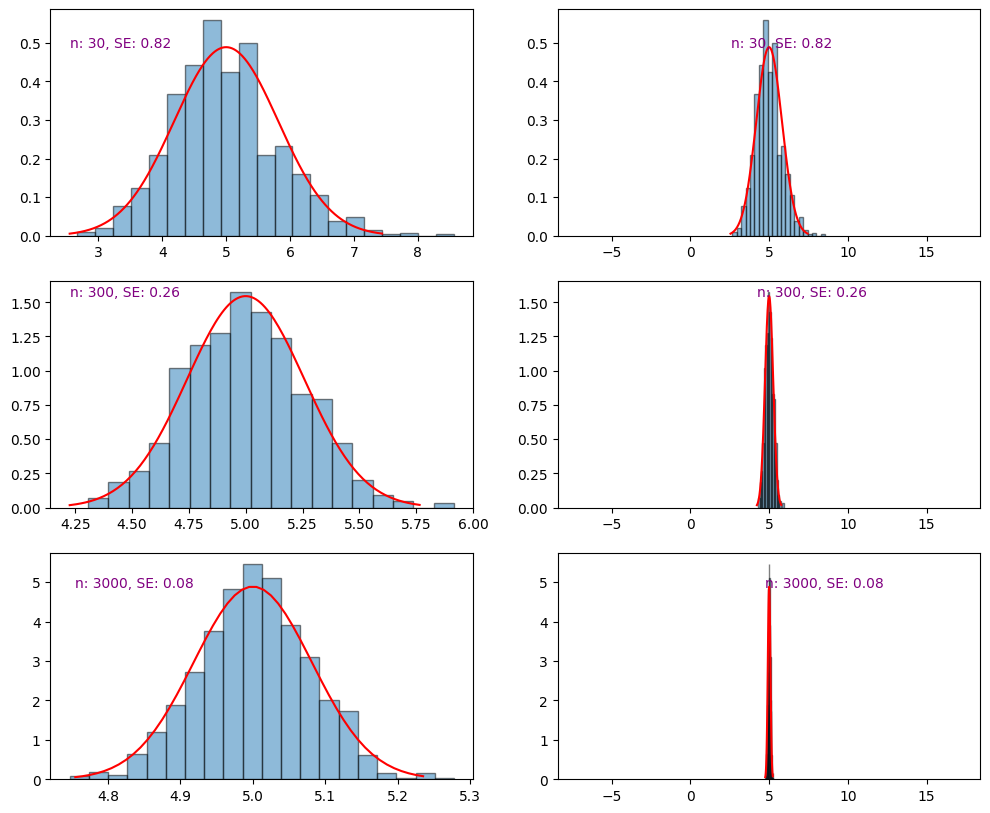

In [79]:
fig, axes = plt.subplots(3, 2, figsize=(12,10))
for i in range(3):
    dist = GeomDistCLT(p=0.2, size=nSamples[i])
    dist.run()
    dist.plot_clt_norm(axes[i][0])
    dist.plot_sampling_hist(axes[i][0])
    dist.plot_clt_norm(axes[i][1])
    dist.plot_sampling_hist(axes[i][1])
    plt.setp(axes[i][1], xlim = [dist.get_mean() - 3 * dist.get_s(), dist.get_mean() + 3 * dist.get_s()])

In [41]:
def unfair_coin(p: float, n: int):
    assert 0 <= p <= 1
    return np.random.choice([0, 1], size=n, p=[1 - p, p])


nSamples = [30, 100, 1000]
for n in nSamples:
    samples = unfair_coin(0.55, n)
    x_bar = samples.mean()
    SE = samples.std() / np.sqrt(n)
    u0 = 0.5
    z = (x_bar - u0) / SE
    print(f'n: {n}, z-score: {z}, p-value: {stats.norm.sf(abs(z)) * 2}')
    

n: 30, z-score: 0.736876126183612, p-value: 0.4611976834915784
n: 100, z-score: 0.40032038451271823, p-value: 0.6889205558044604
n: 1000, z-score: 4.994298065641238, p-value: 5.905013988213766e-07


In [42]:
import pandas as pd

data = pd.read_csv('job_placement.csv')

In [43]:
a = data[data['placement_status'] == 'Placed']['gpa']
b = data[data['placement_status'] == 'Not Placed']['gpa']

In [44]:
degree_of_freedom = a.shape[0] + b.shape[0] - 2
s = np.sqrt((a.var() * (a.shape[0] - 1) + b.var() * (b.shape[0] - 1)) / (degree_of_freedom))
t_statistic = (a.mean() - b.mean()) / (s * np.sqrt(1 / a.shape[0] + 1 / b.shape[0]))
p_value = stats.t.sf(t_statistic, df = degree_of_freedom) * 2

print('degree of freedom:', degree_of_freedom)
print('T-statistic:', t_statistic)
print('p-value:', p_value)


degree_of_freedom: 698
t-statistic: 5.105318956468754
p_value: 4.2636444940967887e-07


In [45]:
t_stat, p_value = stats.ttest_ind(a, b)
print("Test statistic:", t_stat)
print("p-value:", p_value)

Test statistic: 5.105318956468754
p-value: 4.2636444940967887e-07
